In [ ]:
# install the libraires
!pip install sentence-transformers --quiet
!pip install yellowbrick --quiet

In [ ]:
# import the libraries
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
import tensorflow as tf

In [ ]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# read the cleaned data from Titter
tweets = pd.read_csv('/content/drive/MyDrive/LMU/Courses/2Semester 2/3Strategic Analytics/reMarkable/Modeling/Final/clean_reMarkable2_updated_tweets.csv')
tweets.head(1)

,Unnamed: 0,tweet.text,tweet.created_at,tweet.entities,tweet.source,user.created_at,user.location,user.verified,tweet.retweet_count,tweet.reply_count,tweet.like_count,tweet.quote_count,user.followers_count,user.following_count,user.tweet_count,user.listed_count,polarity,subjectivity
0,0,my is sleeping and i cannot wake it up by any ...,2022-04-26 14:38:32+00:00,"{'mentions': [{'start': 197, 'end': 213, 'user...",Twitter for Mac,2009-05-15 14:40:55+00:00,cologne,0.0,0,1,0,0,171,344,4855,6,-0.1875,0.775


In [ ]:
# show the number of rows
tweets.shape

(2385, 18)

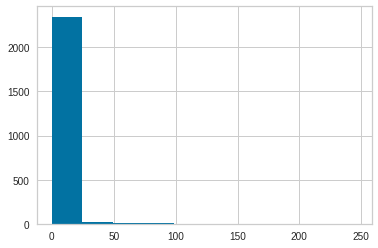

In [ ]:
# show the distribution of the Tweets by the number of likes
tweets['tweet.like_count'].hist()

In [ ]:
# due to the smal number of tweets it's better to not filter anything out

# get tweets that have more than 0 likes
tweets = tweets[tweets['tweet.like_count'] >10]

# select only negative reviews to identify the problems
tweets = tweets[tweets['polarity'] < 0]
tweets.shape

(118, 18)

In [ ]:
#tweets = tweets.sample(n = 100)

In [ ]:
tweets.shape

(118, 18)

# Check if GPU is available

In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


# Define BERT sentence embedding

In [ ]:
# this function uses simple BERT embedding
def simple_bert_embedding(data, model = 'all-MiniLM-L6-v2'):
  # use model
  embedder = SentenceTransformer(model)

  # load sentences into corpus
  corpus = data['tweet.text'].to_list()
  corpus_embeddings = embedder.encode(corpus)

  return corpus, corpus_embeddings

# KMeans Clustering

## Step 1: Embedding. 3.1 Format Data

In [ ]:
# there might be tweets that only contain numbers, so we need to convert them to string
tweets['tweet.text'] = tweets['tweet.text'].astype(str)

In [ ]:
# embed tweets
corpus, corpus_embeddings = simple_bert_embedding(tweets)
print(corpus[0:5])
print(corpus_embeddings[0:5])

['my remarkable2 has not just changed the way i teach, but the way i read. i have always made notes whilst reading but now i can make notes on as many books as i like.', 'no matter what you think of - this video is really well done! watch it.', 'check out my new electronic notepad! i am sooo in love!!!!! it even sounds like paper.', 'getting to grips with my new gadget the 2. well worth the investment. easy to make notes and annotate documents. saves a lot on printing! links easily to google or one drive via the app. no more paper for me!', "i love my remarkable2 and use it for hours most days. but writing/reading is all you can do on it and there is no color on the screen (just shades of gray). on my convertible laptop, i've happily used pdfannotator software for years, but it's not as paper-like as the remarkable."]
[[ 0.00998729 -0.11050311 -0.04017838 ... -0.00506546 -0.10432909
   0.02994178]
 [-0.04612472 -0.01279768  0.02329876 ...  0.05153711 -0.04185406
  -0.01313609]
 [-0.124

In [ ]:
# combine text and embeddings in one dataframe
#text_embeddings = pd.DataFrame({'Text':corpus, 'Embeddings': list(corpus_embeddings)})

In [ ]:
# shoe the number of dimensions of the embeddings
len(corpus_embeddings[0])

384

In [ ]:
# add the embeddings column to the dataset
tweets['embeddings'] = list(corpus_embeddings)

# move the column to the beginning for ease of use
column_to_move = tweets.pop("embeddings")

# insert column with insert(location, column_name, column_value)
tweets.insert(1, "embeddings", column_to_move)

In [ ]:
tweets.head()

,Unnamed: 0,embeddings,tweet.text,tweet.created_at,tweet.entities,tweet.source,user.created_at,user.location,user.verified,tweet.retweet_count,tweet.reply_count,tweet.like_count,tweet.quote_count,user.followers_count,user.following_count,user.tweet_count,user.listed_count,polarity,subjectivity
25,25,"[0.009987292, -0.110503115, -0.040178385, 0.02...",my remarkable2 has not just changed the way i ...,2022-04-16 14:47:45+00:00,"{'urls': [{'start': 184, 'end': 207, 'url': 'h...",Twitter for Android,2014-06-12 21:55:39+00:00,"Uppingham, England",False,0,3,15,0,26046,24313,15077,95,0.500000,0.500000
31,31,"[-0.046124715, -0.01279768, 0.023298763, -0.12...",no matter what you think of - this video is re...,2022-04-15 15:54:48+00:00,"{'urls': [{'start': 175, 'end': 198, 'url': 'h...",Twitter Web App,2008-05-22 10:06:08+00:00,"iPhone: 41.224133,1.783994",False,13,38,58,1,3365,3373,11364,45,0.250000,0.200000
34,34,"[-0.12493445, -0.091411814, 0.07706887, -0.027...",check out my new electronic notepad! i am sooo...,2022-04-15 00:59:17+00:00,"{'urls': [{'start': 106, 'end': 129, 'url': 'h...",Twitter for iPhone,2021-02-27 04:15:28+00:00,Cloud 9,False,2,18,61,3,20618,16334,39473,7,0.585227,0.527273
55,55,"[-0.13943607, 0.033773363, 0.027743392, 0.0088...",getting to grips with my new gadget the 2. wel...,2022-04-09 11:52:19+00:00,"{'urls': [{'start': 243, 'end': 266, 'url': 'h...",Twitter for iPhone,2012-06-02 14:49:27+00:00,NaN,False,1,7,22,0,8606,1012,13905,59,0.219773,0.544242
91,91,"[-0.05229013, -0.01654956, -0.037743654, 0.006...",i love my remarkable2 and use it for hours mos...,2022-03-26 16:19:48+00:00,"{'mentions': [{'start': 0, 'end': 10, 'usernam...",Twitter Web App,2009-03-19 21:15:43+00:00,"State College, PA",False,0,6,54,0,223,901,1007,0,0.637500,0.712500


In [ ]:
# this can be considered a subsistution for our pkl file. 
# since the embeddings are the fundamental component nedded for the model
tweets.to_csv('reMarkable_tweets_embeddings.csv')

## Step 2. K-means clustering and distance from the centroid.

In [ ]:
## Import libraries
from nltk.cluster import KMeansClusterer
import nltk

import numpy as np
from scipy.spatial import distance_matrix

def clustering_tweets(data,NUM_CLUSTERS = 6):

    sentences = data['tweet.text']

    X = np.array(data['embeddings'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid'] = data['cluster'].apply(lambda x: kclusterer.means()[x])

    return data, assigned_clusters

clustering_tweets(tweets, 10)



tweets.head()

,Unnamed: 0,embeddings,tweet.text,tweet.created_at,tweet.entities,tweet.source,user.created_at,user.location,user.verified,tweet.retweet_count,...,tweet.like_count,tweet.quote_count,user.followers_count,user.following_count,user.tweet_count,user.listed_count,polarity,subjectivity,cluster,centroid
25,25,"[0.009987292, -0.110503115, -0.040178385, 0.02...",my remarkable2 has not just changed the way i ...,2022-04-16 14:47:45+00:00,"{'urls': [{'start': 184, 'end': 207, 'url': 'h...",Twitter for Android,2014-06-12 21:55:39+00:00,"Uppingham, England",False,0,...,15,0,26046,24313,15077,95,0.500000,0.500000,7,"[-0.052500762, -0.045996923, -0.0025163242, 0...."
31,31,"[-0.046124715, -0.01279768, 0.023298763, -0.12...",no matter what you think of - this video is re...,2022-04-15 15:54:48+00:00,"{'urls': [{'start': 175, 'end': 198, 'url': 'h...",Twitter Web App,2008-05-22 10:06:08+00:00,"iPhone: 41.224133,1.783994",False,13,...,58,1,3365,3373,11364,45,0.250000,0.200000,2,"[-0.06131458, 0.007404467, 0.04225289, -0.0325..."
34,34,"[-0.12493445, -0.091411814, 0.07706887, -0.027...",check out my new electronic notepad! i am sooo...,2022-04-15 00:59:17+00:00,"{'urls': [{'start': 106, 'end': 129, 'url': 'h...",Twitter for iPhone,2021-02-27 04:15:28+00:00,Cloud 9,False,2,...,61,3,20618,16334,39473,7,0.585227,0.527273,3,"[-0.079515055, -0.006933542, 0.017396823, -0.0..."
55,55,"[-0.13943607, 0.033773363, 0.027743392, 0.0088...",getting to grips with my new gadget the 2. wel...,2022-04-09 11:52:19+00:00,"{'urls': [{'start': 243, 'end': 266, 'url': 'h...",Twitter for iPhone,2012-06-02 14:49:27+00:00,NaN,False,1,...,22,0,8606,1012,13905,59,0.219773,0.544242,3,"[-0.079515055, -0.006933542, 0.017396823, -0.0..."
91,91,"[-0.05229013, -0.01654956, -0.037743654, 0.006...",i love my remarkable2 and use it for hours mos...,2022-03-26 16:19:48+00:00,"{'mentions': [{'start': 0, 'end': 10, 'usernam...",Twitter Web App,2009-03-19 21:15:43+00:00,"State College, PA",False,0,...,54,0,223,901,1007,0,0.637500,0.712500,7,"[-0.052500762, -0.045996923, -0.0025163242, 0...."


In [ ]:
# we need to reset index because we deleted some of the original rows before. Filtered by te number of likes.
tweets = tweets.reset_index()

In [ ]:
# # visualize the clusters in reduced dimentionality
# # https://www.kaggle.com/code/ellecf/visualizing-multidimensional-clusters/notebook
# # https://cmdlinetips.com/2018/03/pca-example-in-python-with-scikit-learn/

# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np
# %matplotlib inline

# load decomposition to do PCA analysis with sklearn
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pc = pca.fit_transform(np.array(tweets['embeddings'].tolist()))


In [ ]:
# pc_df = pd.DataFrame(data = pc , 
#         columns = ['PC1', 'PC2', 'PC3'])
# pc_df['Cluster'] = tweets.cluster
# pc_df.head(5)

,PC1,PC2,PC3,Cluster
0,-0.257807,-0.263543,0.077290,0
1,-0.311496,0.068651,0.172243,3
2,-0.316313,0.046590,-0.103935,1
3,0.010469,0.458206,0.132336,3
4,-0.127782,-0.149057,-0.082898,3


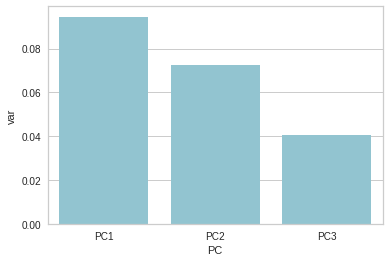

In [ ]:
# % of variance exmplained by
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2', 'PC3']})
sns.barplot(x='PC',y="var", 
           data=df, color="c");

In [ ]:
# # our PCA explains total % of variation
# df['var'].sum()

0.20768575

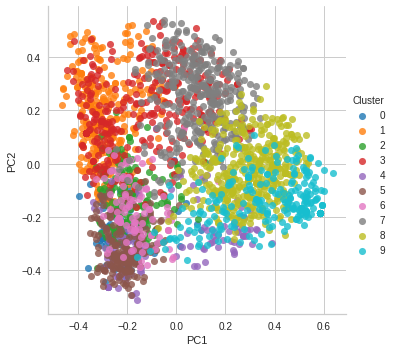

In [ ]:
# # plot the clusters in 2 dimentions
# sns.lmplot( x="PC1", y="PC2",
#   palette = "tab10", # https://seaborn.pydata.org/tutorial/color_palettes.html
#   data=pc_df, 
#   fit_reg=False, 
#   hue='Cluster', # color by cluster
#   legend=True,
#   scatter_kws={"s": 50}) # specify the point size

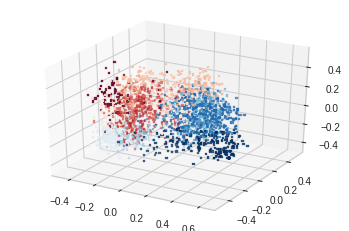

In [ ]:
# # plot the clusters in 3 dimensions
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import pandas as pd
# import numpy as np



# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# x = np.array(pc_df['PC1'])
# y = np.array(pc_df['PC2'])
# z = np.array(pc_df['PC3'])

# ax.scatter(x,y,z, marker="s", c=pc_df["Cluster"], s=5, cmap="RdBu")

# plt.show()


In [ ]:
# calculating the distance from the centroid to find the most representative sentences
def distance_from_centroid(row):
    # type of emb and centroid is different, hence using tolist below
    return distance_matrix([row['embeddings']], [row['centroid'].tolist()])[0][0]


# Compute centroid distance to the data
tweets['distance_from_centroid'] = tweets.apply(distance_from_centroid, axis=1)

In [ ]:
# tweets.to_csv('reMarkable_analysed_dataset.csv')

KeyboardInterrupt: ignored

In [ ]:
sorted_tweets = tweets.sort_values(by = ['cluster', 'distance_from_centroid'])[['tweet.text', 'cluster', 'distance_from_centroid']]

In [ ]:
sorted_tweets

,tweet.text,cluster,distance_from_centroid
44,the remarkable2 is worth it alone just to remi...,0,0.556198
14,spending the weekend cleaning my uncles apartm...,0,0.709915
58,i wish there was an economist &amp; ft app for...,0,0.749116
92,was helping kiddo with precal homework. i got ...,0,0.752610
28,here it is my christmas present from main man....,1,0.695393
...,...,...,...
108,just receive my new geek device i badly want t...,9,0.816953
23,sometimes it's just easier to think without co...,9,0.869101
49,hello there!,9,0.935910
90,setting up a bbs over packet radio today to co...,9,0.956422


In [ ]:
# show top 3 from each cluster
top_tweets = []
n_clusters = sorted_tweets.cluster.max()+1
#print(n_clusters)

for cluster in range(n_clusters):
  #print(cluster)
  for top in range(3):
    top_tweets.append(sorted_tweets[sorted_tweets['cluster']==cluster].iloc[top,:])
    #print(sorted_tweets[sorted_tweets['cluster']==cluster].iloc[top,:])
  
top_tweets = pd.DataFrame(top_tweets)
top_tweets

,tweet.text,cluster,distance_from_centroid
44,the remarkable2 is worth it alone just to remi...,0,0.556198
14,spending the weekend cleaning my uncles apartm...,0,0.709915
58,i wish there was an economist &amp; ft app for...,0,0.749116
28,here it is my christmas present from main man....,1,0.695393
82,woooo! grad school gift for myself came in today!,1,0.744483
75,it's here! new toy!,1,0.754324
5,"the finished sketch from today's stream, a gif...",2,0.708715
36,where science meets art. this is an imperfect ...,2,0.713274
15,finally finally got started on the for very ea...,2,0.751689
77,"as much as i love pen and paper, i really am f...",3,0.621450


In [ ]:
top_tweets.to_csv('popular_only_reMarkable_top_tweets_10.csv')

# Play with SMMRY
https://smmry.com/